In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sounddevice as sd
from scipy.signal import chirp,windows
from math import  floor,ceil
from random import  random
def cos_signal(freq,t,a=1,phase=0):
     return np.cos(2*np.pi*freq*t+phase*np.pi)
def chirp_signal(freq,t,a=1):
     return chirp(t,f0=freq-5,f1=freq,t1=1)
signal_basis=[cos_signal,chirp_signal]

def next_power_of_2(x):
  if x <= 0:
    return 1  # 2^0 = 1, the smallest power of 2

  k = math.ceil(math.log2(x + 1)) #log base 2 of x+1 and rounded up
  return 2**k

def str2sig(data,freq_min,freq_max,clock_time,sampling_rate,level,init_freq=0,ampitude=1,phase=0,is_phase_random=False,full_plot=False):
     

     tmp=[]
     N=len(data)
     sampling = sampling_rate
     clock_time=clock_time/math.pow(2,level)
     t=np.linspace(0,clock_time,ceil(sampling*clock_time))
     #window=1
     window = windows.tukey(ceil(sampling*clock_time),1.5/2**level)
     
     freq_min+=init_freq
     freq_max+=init_freq
     #print(data,freq_min,freq_max,clock_time,sampling_rate*clock_time)
     for i in data:
          match i:
               case '1':tmp.append(signal_basis[0](freq_max,t,phase=np.pi*(freq_min/180 if not is_phase_random else random()))*window)
               case '0':tmp.append(signal_basis[0](freq_min,t,phase=np.pi*(freq_min/180 if not is_phase_random else random()))*window)
               case '2':tmp.append(t*0)
     x=np.concatenate(tmp)
     #print("len",len(x))
     if(full_plot):
          plt.figure(figsize=(60,5))
          plt.plot(np.linspace(0,N*clock_time,N*ceil(sampling*clock_time)),x)
     #print(x)
     return x
     
def generator_signal(data,freq_padding,time_per_changed,times,init_freq=0,sampling_rate=-1,dynamic_padding=False,_step_factor=1,full_plot=False):
     
     y_in=[]
     N=len(data)
     maxnum_per_freq=int(floor(times/time_per_changed))
     times=maxnum_per_freq*time_per_changed # fitting time with time_per_changes
     level = int(math.ceil(math.log2(N/maxnum_per_freq+1)))
     padding_char = '2'*(maxnum_per_freq*int(math.pow(2,level))-N)
     data=data + (padding_char)
     #print(level)
     segment_freq=[]
     _freq_padding=freq_padding
     _acumulate_freq = 0
     _count=0
     for i in range(1,level*2,2):
          if(dynamic_padding):
               _acumulate_freq+=_freq_padding
               segment_freq.append( [_acumulate_freq,_acumulate_freq+_freq_padding])
               #print("gg",_acumulate_freq,_freq_padding+_acumulate_freq)
               _acumulate_freq+=_freq_padding
               _count+=1
               if(_count%_step_factor==_step_factor-1):
                    _freq_padding*=2
          else:segment_freq.append([i*freq_padding,(i+1)*freq_padding])

     
     sampling_freq = max((2*next_power_of_2(np.max(segment_freq))),sampling_rate)
     # splice data
     count=0
     datas = [data[maxnum_per_freq*(int(math.pow(2,i))-1):min(maxnum_per_freq*(int(math.pow(2,i+1)-1)),len(data))] for i in range(level)]
     y_out=np.zeros(ceil(times*sampling_freq))
     #print(sampling_freq)
     for i in range(level):
          tmp=str2sig(datas[i],segment_freq[i][0],segment_freq[i][1],time_per_changed,sampling_freq,init_freq=init_freq,level=i,phase=(i*np.pi/level),is_phase_random=False)
          y_in.append(tmp)
          y_out+=tmp
     if(full_plot):
          plt.figure(figsize=(60,5))
          plt.plot(np.linspace(0,times,ceil(times*sampling_freq)),y_out)
     return [segment_freq,y_out,y_in,datas,sampling_freq,freq_padding,time_per_changed,times]

In [3]:
test_str="Hello,  improves data transmission efficiency."
res = str(''.join(format(ord(i), '08b') for i in test_str))
print(res)


segment_freq,comb_signal,input_seperate_signal,datas,sampling_freq,freq_padding,time_per_change,all_time=generator_signal(res,16,1,1,init_freq=0,dynamic_padding=False,_step_factor=3)
print("max_ampitude",np.max(np.abs(comb_signal)))


01001000011001010110110001101100011011110010110000100000001000000110100101101101011100000111001001101111011101100110010101110011001000000110010001100001011101000110000100100000011101000111001001100001011011100111001101101101011010010111001101110011011010010110111101101110001000000110010101100110011001100110100101100011011010010110010101101110011000110111100100101110
max_ampitude 5.913682749801804


In [4]:
sd.play(comb_signal,sampling_freq)

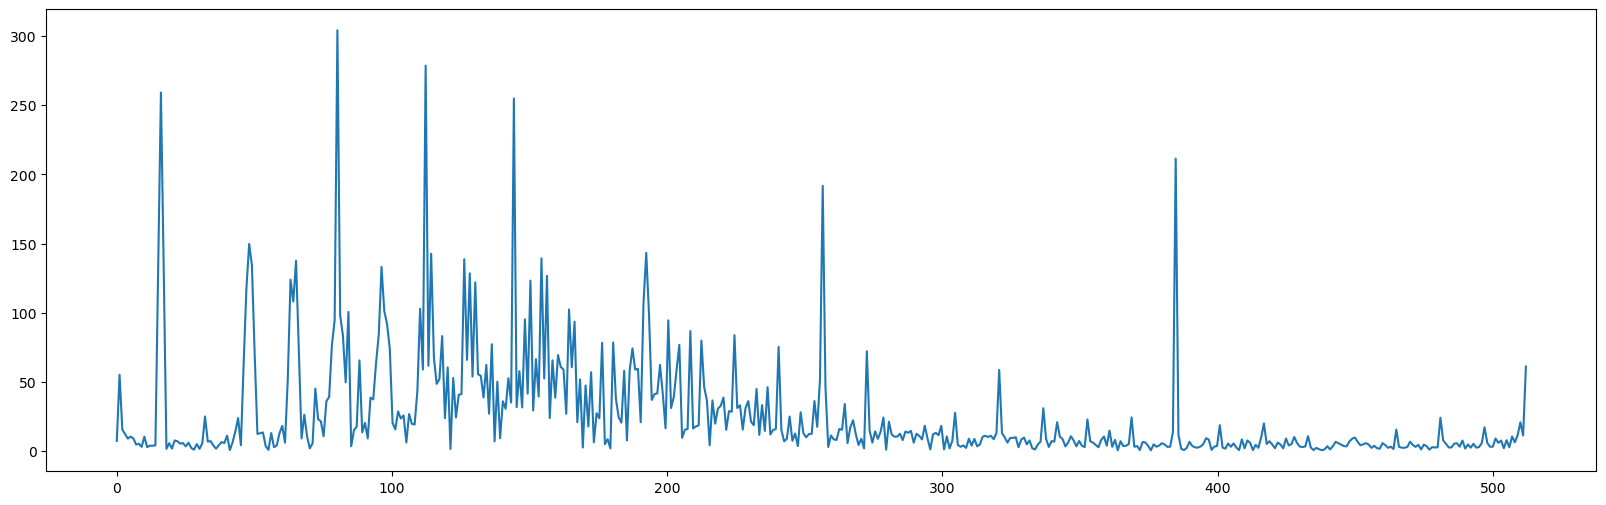

In [5]:
coef = np.fft.fft(comb_signal)
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0,(len(coef))//2,int(len(coef))//2),np.abs(coef[:len(coef)//2]))

Perform Signal Processing

In [6]:
import numpy as np
from scipy.signal import butter, filtfilt,find_peaks,firwin
import matplotlib.pyplot as plt

segment_freq,comb_signal,input_seperate_signal,datas,sampling_freq,freq_padding,time_per_change,all_time \
=generator_signal(res,16,1,1,init_freq=0,dynamic_padding=False,_step_factor=5)
decode_binary=[]

def duplicate_signal(signal,n=1):
     return [signal for _ in range(n)]



def butter_bandpass(lowcut, highcut, fs, order=1):
    #print("lowcut:",lowcut)
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def filter_signal(signals, filter_segments, sampling_freq, times, full_plot=False, order=5):
  
    filtereds = []
    padding_segment = []
    
    
    padding_segment.append(float(filter_segments[0][0]))
    padding_segment.extend([
        float(filter_segments[i+1][0] - filter_segments[i][1]) 
        for i in range(len(filter_segments)-1)
    ])
    padding_segment.append(sampling_freq/2 - float(filter_segments[-1][1]))
    
    nyq = sampling_freq / 2.0
    
    for index, seg in enumerate(filter_segments):
        # Adjust lowcut and highcut using half of the padding before and after
        lowcut = max(0, seg[0] - padding_segment[index] / 2)
        highcut = min(nyq, seg[1] + padding_segment[index+1] / 2)
        
        # Normalize frequencies for filter design
        low = lowcut / nyq
        high = highcut / nyq
        print(lowcut,highcut)

        # Apply zero-phase filtering using filtfilt
        

        
        # Design Butterworth bandpass filter
        b, a = butter(order, [low, high], btype='band')
        
        # Apply zero-phase filtering
        filtered_signal = filtfilt(b, a, signals[index])
        
        filtereds.append(filtered_signal)
        
        if full_plot:
            t = np.linspace(0, times, len(filtered_signal))
            plt.figure(figsize=(20, 4))
            plt.plot(t, filtered_signal)
            plt.title(f'Filtered Signal for Segment {index}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.show()
            
    return filtereds

def auto_padding_with_window(signal, target, window_type=None,is_zero=False,full_plot=False):
    signal = np.array(signal)
    N = len(signal)

    if target <= N:
        return signal
    full_reps = target // N
    remainder = target % N

   
    if window_type == 'hann':
        window = np.hanning(N)
    elif window_type == 'hamming':
        window = np.hamming(N)
    else:
        window = np.ones(N)  

    windowed_segment = signal * window
    segments=[]
    if(is_zero):
        segments.append(windowed_segment)
        segments.append(np.zeros(target-N))
    else:
        segments = [windowed_segment] * full_reps

        if remainder > 0:
            partial_window = window[:remainder]
            windowed_partial = signal[:remainder] * partial_window
            segments.append(windowed_partial)

    padded_signal = np.concatenate(segments)
    if(full_plot):
        plt.figure(figsize=(10, 4))
        plt.plot(np.linspace(0, target, len(padded_signal)), padded_signal)
        plt.title("Auto Padded Signal with Windowing")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.show()
    
    

    return padded_signal

def fft_range(time_per_change,fs,fsignal,segment_freq,full_plot=False):
     
     #print(np.array(fsignal).shape)
     sort_layer_coeff=[]
     for level in range(0,len(segment_freq)):
          sort_coeff = []
          nperseg = math.ceil(time_per_change*fs/(math.pow(2,level)))
          #print('nperseg',nperseg)
          number_segment = math.floor(len(fsignal[0])/nperseg) 
          
          mid_freq = int((segment_freq[level][0]+segment_freq[level][1])/2)
          fadding_count=0
          for i in range(number_segment):
               

               index_min = int(max(0,i*(nperseg)))
               index_max = int(min((i+1)*(nperseg),len(fsignal[0])-1))
               #print(i,index_min,index_max)
               zero_padding_signal = auto_padding_with_window(fsignal[level][index_min:index_max],fs,is_zero=True)
               #print("pading",len(zero_padding_signal))

               fft_out =np.fft.fft(zero_padding_signal)
               frequencies = np.fft.fftfreq(len(zero_padding_signal), d=1/fs)
               mask = (np.abs(frequencies) >= segment_freq[level][0]) & (np.abs(frequencies) <= segment_freq[level][1])
               fft_masked = fft_out*mask
               fft_out = fft_masked[:len(fft_masked)//2]**2
               if(full_plot):

                    plt.figure(figsize=(20,6))
                    plt.plot(np.linspace(0,len(fft_out),len(fft_out)),np.abs(fft_out))
               fft_index = list(enumerate(fft_out))
               #find peak freq
               peak_freq=0
               peak_value=0
               peaks, properties = find_peaks(np.abs(fft_out), height=0.1*0.2235*math.pow(nperseg,2))
               if len(peaks) > 0:
                    max_peak_index = peaks[np.argmax(properties['peak_heights'])]
                    peak_freq = frequencies[max_peak_index]
                    peak_value = np.abs(fft_out[max_peak_index])
               else:
                    peak_freq = None
            
               fft_index.sort(key=lambda x:np.abs(x[1]),reverse = True)
               #print(np.abs(fft_index[0][1]),0.2235*math.pow(nperseg,2))
               #print(f"level:{level},segment:{i},{fft_index[0][0]>mid_freq} max_freq {fft_index[0][0]}[min{segment_freq[level][0]}:max{segment_freq[level][1]}],mid:{mid_freq}indmin:{index_min},indmax{index_max}")
               if(peak_freq==None or  peak_value <0.2235*math.pow(nperseg,2)*0.1):
                   if(fadding_count==3):
                       break
                   fadding_count+=1
                
                  
               elif(peak_freq <mid_freq): 
                   decode_binary.append('2'*fadding_count)
                   fadding_count=0
                   decode_binary.append('0')

               else:
                   decode_binary.append('2'*fadding_count)
                   fadding_count=0

                   decode_binary.append('1')
               #sort_coeff.append(fft_index)
          sort_layer_coeff.append(sort_coeff)
     
     return sort_layer_coeff

used_filtered=True
dublicate_signal = duplicate_signal(comb_signal,len(segment_freq))
filter_signals = dublicate_signal if not used_filtered else filter_signal(dublicate_signal,segment_freq,sampling_freq,all_time)
fft_coeff = fft_range(time_per_change,sampling_freq,filter_signals,segment_freq)
string_out = ''.join(decode_binary)

def compare_string(target,test):
    N=len(target)
    if(N>len(test)):
        test+='2'*(N-len(test))
    count=0
    for i in range(N):
        count+=1 if target[i]==test[i] else 0
    return count*100/N
print(res)
print(string_out)
print("percent: ",compare_string(res,string_out))





8.0 40.0
40.0 72.0
72.0 104.0
104.0 136.0
136.0 168.0
168.0 200.0
200.0 232.0
232.0 264.0
264.0 400.0
01001000011001010110110001101100011011110010110000100000001000000110100101101101011100000111001001101111011101100110010101110011001000000110010001100001011101000110000100100000011101000111001001100001011011100111001101101101011010010111001101110011011010010110111101101110001000000110010101100110011001100110100101100011011010010110010101101110011000110111100100101110
0100100001100101011011000110110111100111010001011121111111001110020021102002011111222000001100010221001200001111000000021100011100100001100022111100000111000022100002210000121220112212221121121
percent:  26.08695652173913


In [7]:
from scipy.signal import  correlate

for i in range(len(filter_signals)):
     c_out = correlate(input_seperate_signal[i],filter_signals[i])
     c1_out = correlate(input_seperate_signal[i],input_seperate_signal[i])
     print((np.max(c_out)/np.max(c1_out))*100)

101.99975555906775
91.22977988884956
98.93722394537676
92.94827477163537
75.71222129884208
41.56008124279292
7.021837618453354
36.47082830139912
18.630095407659542
